# Full flow: preprocess, train and predict
Full flow of all modules implemented. Change `modeltype` to test differens models

In [1]:
from utils.preprocessing import preprocess_videos
from utils.ModelWrapper import ModelWrapper, ModelType
import tensorflow as tf
from utils.predict import predict_multiple
from utils.dot_dict import Dotdict
import wandb

## Init configuration
Change the configuration here

In [2]:
USE_WANDB = True
MODEL_TYPE = ModelType.CNN

### Preprocess

In [3]:
# takes approx 6 min
datasets = {
    "train": ["train"], # Train dataset folders, now points to sample files
    "test": ["test"], # Test dataset fodler, not points to sample files
}

# When processing full directories remove skip_sampling=True because we don't need 50/50 split in the example.
preprocess_videos(datasets, save_dir="data", video_dir="sample", skip_sampling=True)

Processing train datasets
	 Processing train


11it [03:06, 16.91s/it]


Processing test datasets
	 Processing test


10it [03:07, 18.79s/it]


### Train

In [4]:
# Configs
# config_defaults = {
#     'epochs': 3,
#     'batch_size': 32,
#     'learning_rate': 0.0001,
#     'dropout': 0.5,
#     'regularization': 0.0001,
# }

config_defaults = {
    'epochs': 1,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'optimizer': 'adam',
    'hidden_layer_size': 64,
    'conv_layer_1_size': 16,
    'conv_layer_2_size': 32,
    'conv_layer_3_size': 64,
    'dropout': 0.5,
    "use_augmentation": True,
}

if USE_WANDB:
    wandb.init(config=config_defaults, project="deepfake-efficientnet", entity="dat550")
    config = wandb.config
else:
    config = Dotdict(config_defaults)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dat550 (use `wandb login --relogin` to force relogin)


In [5]:
img_size = 128
data_dir = "./data"

Initialize the model

In [6]:
# Initialize the model
model_file = f'models/{MODEL_TYPE.name}/{wandb.run.name}_model.h5'

# init wrapper
model_wrapper = ModelWrapper(data_dir, img_size, config,model_file=model_file, modeltype=MODEL_TYPE, use_wandb=USE_WANDB)
model_wrapper.model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model_wrapper.model.summary()

Found 66 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)       

Train the model

In [7]:
model_wrapper.fit()

1/1 [==============================] - 0s 196ms/steps: 0.6805 - accuracy: 0.62

Epoch 1: val_loss improved from inf to 0.63623, saving model to models/CNN\glowing-vortex-36_model.h5
3/3 [==============================] - 7s 1s/step - loss: 0.6813 - accuracy: 0.6212 - val_loss: 0.6362 - val_accuracy: 0.6250 - _timestamp: 1652529376.0000 - _runtime: 18.0000


Evaluate the model

159/159 [==============================] - 1s 7ms/step
self.test_generator.filenames:  159
preds:  159
conf_matrix: 
 [[140  19]
 [  0   0]]


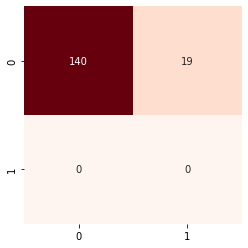

In [8]:
model_to_eval = model_wrapper.model
model_wrapper.evaluate_model(model_to_eval)

### Predict

In [ ]:
result = predict_multiple("./sample/test", model_to_eval, frame_rate=1, plot=False)